# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




##Importing Kaggle Dataset

In [2]:
!unzip /content/drive/MyDrive/fresh_rotten_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

##Importing Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import pathlib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf
import numpy as np

##Loading Dataset

In [4]:
dataset_path = "/content/dataset/train"
dataset_dir = pathlib.Path(dataset_path)
val_path = "/content/dataset/test"
val_dir = pathlib.Path(val_path)

In [5]:
# list of sub directory(class)

class_names = []
for root, dirs, files in os.walk(dataset_path):
    if len(root) > len(dataset_path):
        x_class = os.path.relpath(root, dataset_path)
        class_names.append(x_class)

print(class_names)

['rottenbanana', 'rottenapples', 'freshbanana', 'freshapples', 'freshoranges', 'rottenoranges']


In [6]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.png')))
    print(f"Images in class {class_i}:",image_count)

Images in class rottenbanana: 2224
Images in class rottenapples: 2342
Images in class freshbanana: 1581
Images in class freshapples: 1693
Images in class freshoranges: 1466
Images in class rottenoranges: 1595


In [7]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
tr_split = 0.25
val_split = 0.7

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=tr_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch
)

Found 10901 files belonging to 6 classes.
Using 8176 files for training.


In [8]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )

Found 2698 files belonging to 6 classes.
Using 1888 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


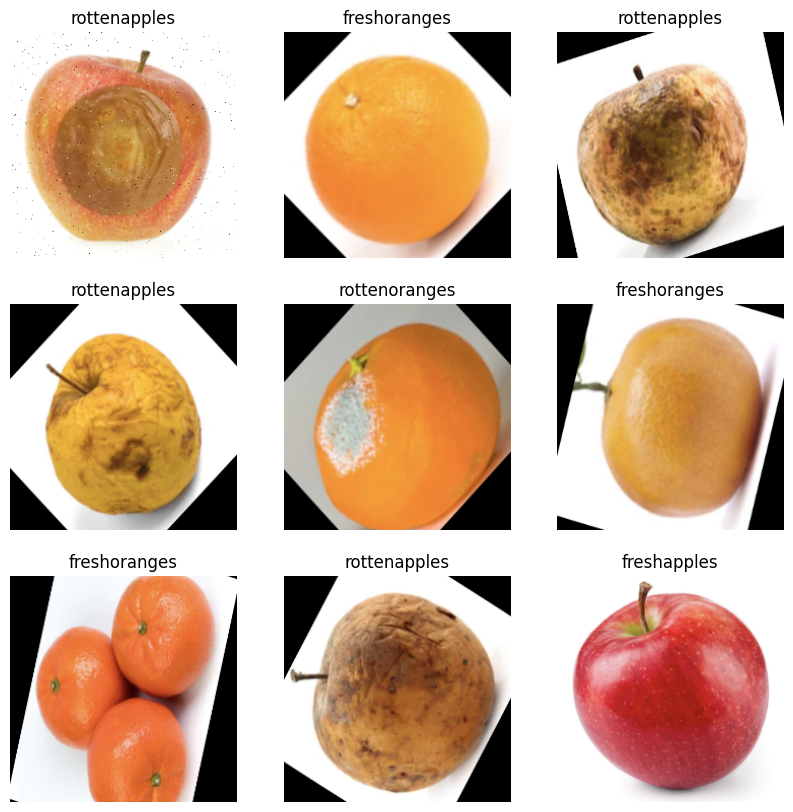

In [10]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Preprocessing

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**CNN Model Building**

In [11]:
#Data augmentation layers to increase data variation for training
data_augmentation = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [49]:
# Model architecture
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

In [66]:
# compile model
base_learning_rate = 0.0005
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [67]:
# display model
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │         802,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 812,822 (3.10 MB)

 Trainable params: 812,694 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

##CNN Model Training

In [68]:
epochs=3
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

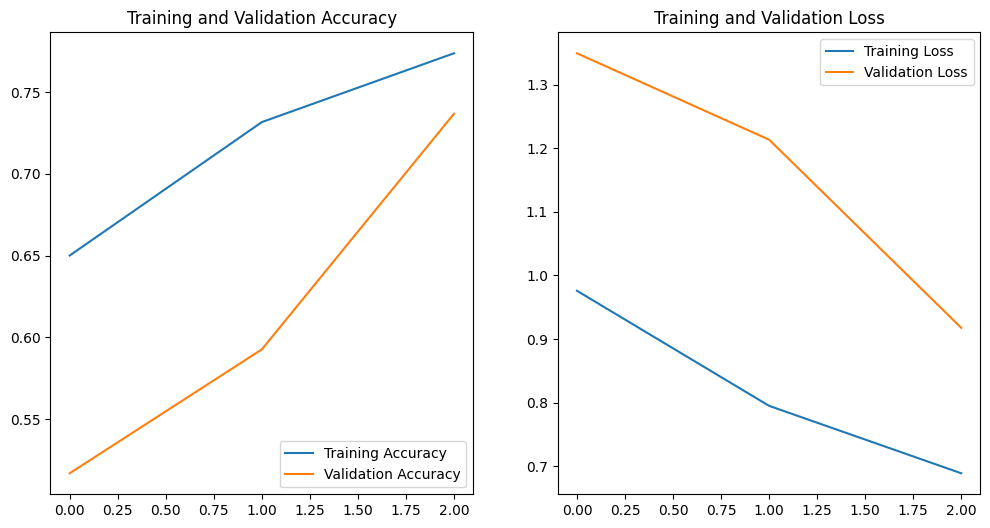

In [69]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Evaluation

Predictions:
 [3 1 4 0 1 1 3 5 1 5 3 3 4 3 3 4 5 3 5 5 5 0 0 4 3 3 3 4 4 0 5 3 0 4 3 3 2
 5 0 3 1 4 5 5 3 0 4 3 3 3 5 3 4 3 4 1 3 3 4 4 3 3 1 3 5 3 3 2 3 4 5 3 4 3
 5 3 3 5 2 5 5 3 3 0 4 3 3 0 2 3 0 3 5 3 3 4 0 3 3 5 4 2 5 5 3 5 4 0 0 3 3
 3 0 5 3 5 3 5 0 1 3 3 3 3 3 4 4 4]
Labels:
 [3 1 4 0 1 1 3 1 1 5 1 3 4 2 3 4 5 3 5 1 3 0 0 4 3 3 3 4 4 0 5 1 0 4 3 3 2
 5 0 0 1 4 5 5 0 0 4 0 0 3 5 3 4 3 4 1 3 3 4 5 5 3 1 2 5 3 2 2 0 4 5 3 4 2
 2 1 3 5 2 5 1 3 3 0 4 3 1 0 2 0 0 2 2 2 0 1 0 3 3 1 4 2 1 5 3 5 4 0 3 0 3
 3 0 1 3 5 0 5 0 1 3 1 2 3 3 4 4 4]

              precision    recall  f1-score   support

           0       0.93      0.61      0.74        23
           1       1.00      0.40      0.57        20
           2       1.00      0.36      0.53        14
           3       0.58      0.94      0.72        33
           4       0.91      1.00      0.95        20
           5       0.64      0.89      0.74        18

    accuracy                           0.73       128
   macro avg       0

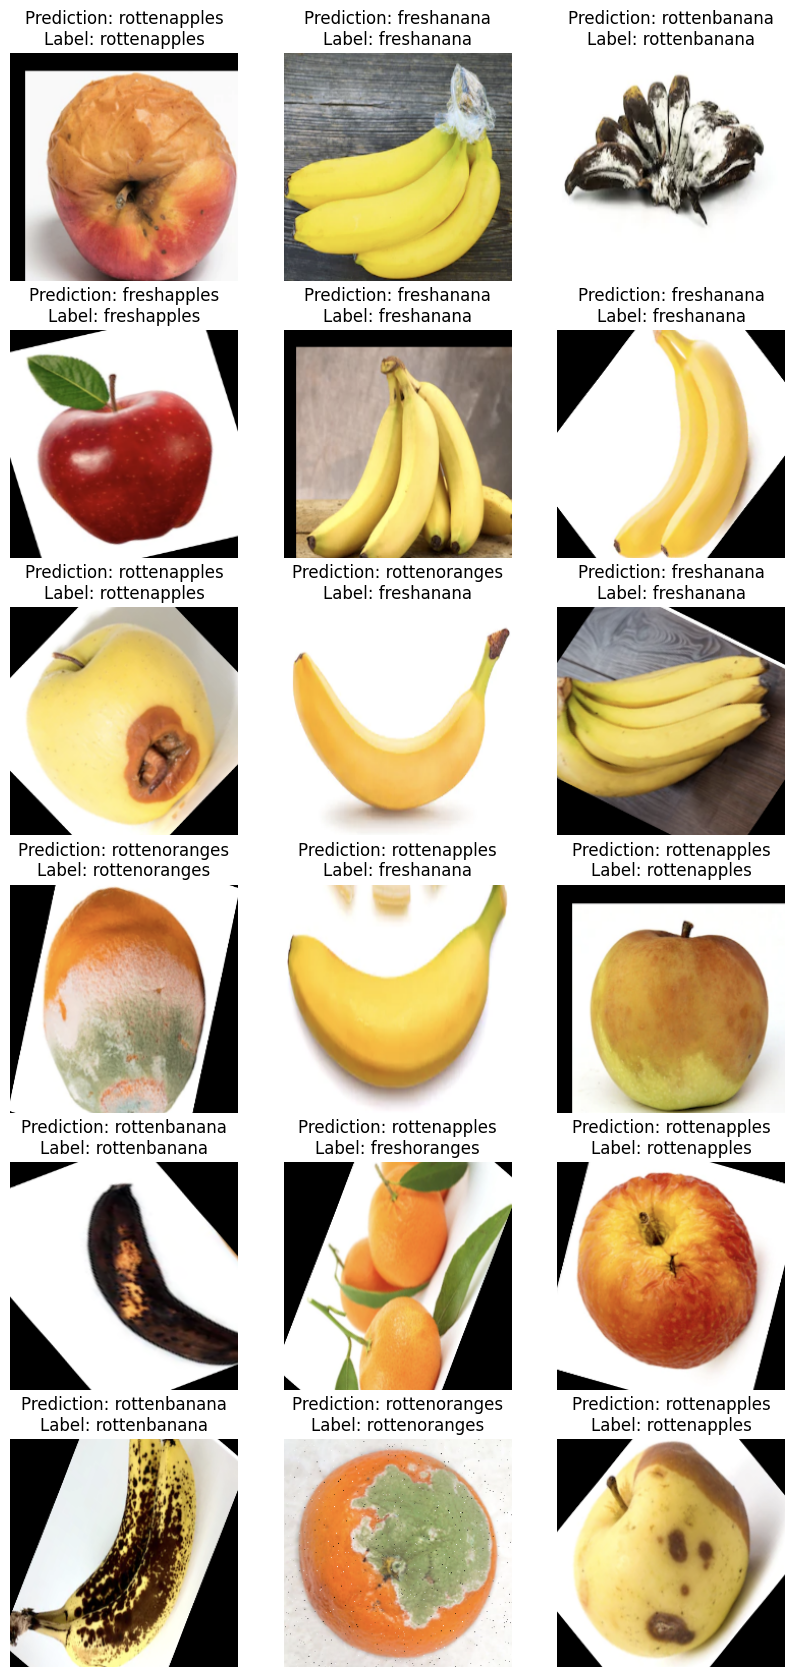

In [70]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = cnn_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

##The CNN Model shows a Testing Accuracy of 82%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


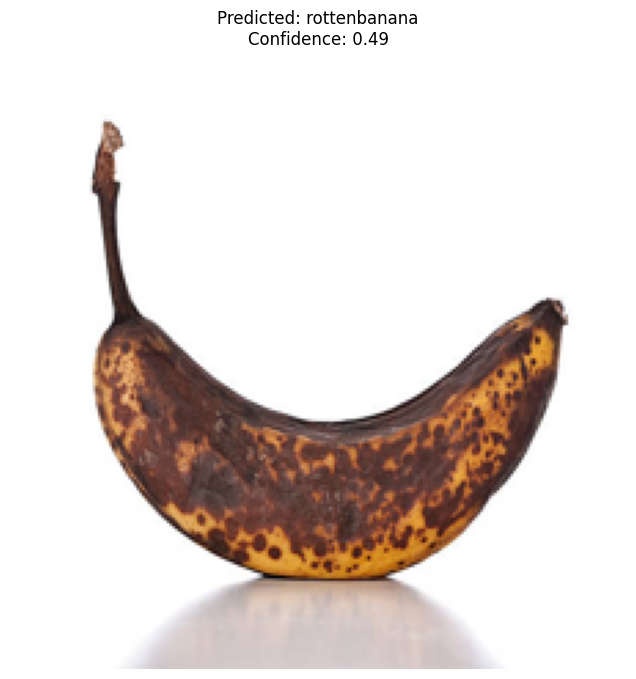

Predicted class: rottenbanana
Confidence: 0.49
Class probabilities:
  freshapples: 0.0796
  freshbanana: 0.0309
  freshoranges: 0.0294
  rottenapples: 0.1801
  rottenbanana: 0.4930
  rottenoranges: 0.1870


In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

def predict_and_display_image(model, img_path, img_height, img_width, confidence_threshold=0.5):
    class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"Error: The file {img_path} does not exist.")
        return
    try:
        # Load and resize the image using bicubic interpolation
        with Image.open(img_path) as img:
            img_resized = img.resize((img_width, img_height), Image.BICUBIC)

        # Convert image to array
        img_array = image.img_to_array(img_resized)

        # Check if the image was loaded correctly
        if img_array.shape != (img_height, img_width, 3):
            print(f"Error: Image shape is {img_array.shape}, expected ({img_height}, {img_width}, 3)")
            return

        # Prepare the image for prediction
        img_array_for_prediction = np.expand_dims(img_array, axis=0)
        img_array_for_prediction = preprocess_input(img_array_for_prediction)

        # Make prediction
        predictions = model.predict(img_array_for_prediction)

        # Get the predicted class and confidence
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        # Get probabilities for all classes
        class_probabilities = {class_name: float(prob) for class_name, prob in zip(class_names, predictions[0])}

        # Display the image with predicted class
        plt.figure(figsize=(8, 8))
        plt.imshow(img_resized)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        # Print prediction details
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
        print("Class probabilities:")
        for class_name, prob in class_probabilities.items():
            print(f"  {class_name}: {prob:.4f}")
    except Exception as e:
        print(f"Error occurred: {str(e)}")


predict_and_display_image(cnn_model, '/content/RB1.jpg', img_height, img_width)